# Predicting Trading Volume - Testing the Performance of Various ML Models

## 1 Project Goal

Given time series data of the New York Stock Exchange (NYSE) from 1962 to 1986, we are building competing machine learning models to forecast the next day's trading volume given data on previous trading volume, Dow Jones index return and trading volatility. Although these factors play a role in impacting trading volume on a given day, it is important to note thet with stock market data there is always high level of uncertainty and multiple factors impacting every movement in the market - from macroeconbomic variables, press conferences with the Central Bank, company performance data, geopolitical environment and even tweets from major business personalities!

Thus, the major focus of this project is to explore different machine learning models, understand their nuances when forecasting time series data and conclude on best performance to draw insights on the features of competing models.

## 2 Data Description and Exploration

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import io
import requests

pd.set_option('display.max_columns', None)    #to display all columns

In [2]:
#reading in NYSE data from url
url = "https://raw.githubusercontent.com/ucla-econ-425t/2023winter/master/slides/data/NYSE.csv"
s = requests.get(url).content.decode('utf-8')
NYSE = pd.read_csv(io.StringIO(s), index_col = 0)
NYSE

,day_of_week,DJ_return,log_volume,log_volatility,train
date,,,,,
1962-12-03,mon,-0.004461,0.032573,-13.127403,True
1962-12-04,tues,0.007813,0.346202,-11.749305,True
1962-12-05,wed,0.003845,0.525306,-11.665609,True
1962-12-06,thur,-0.003462,0.210182,-11.626772,True
1962-12-07,fri,0.000568,0.044187,-11.728130,True
...,...,...,...,...,...
1986-12-24,wed,0.006514,-0.236104,-9.807366,False
1986-12-26,fri,0.001825,-1.322425,-9.906025,False
1986-12-29,mon,-0.009515,-0.371237,-9.827660,False


#### Column Descriptions

- *Log_volume (Target Variable):* This is the fraction of all outstanding shares that are traded on that day, relative to a 100-day moving average of past turnover, on the log scale.
- *DJ_return:* This is the difference between the log of the Dow Jones Industrial Index on consecutive trading days.
- *Log_volatility:* This is based on the absolute values of daily price movements, on the log scale.

We will use only the above columns and their time lags as relevant features for the forecasting of trading volume.

#### Time Series Plots

Plotting the three time series to look at general trends in volatility, returns and trading volume over the given time period.

In [93]:
#creating a copy of original dataset to manipulate dates for visually appealing plot
plots = NYSE.copy()
plots['date'] = pd.to_datetime(plots.date)

In [108]:
from matplotlib.dates import YearLocator

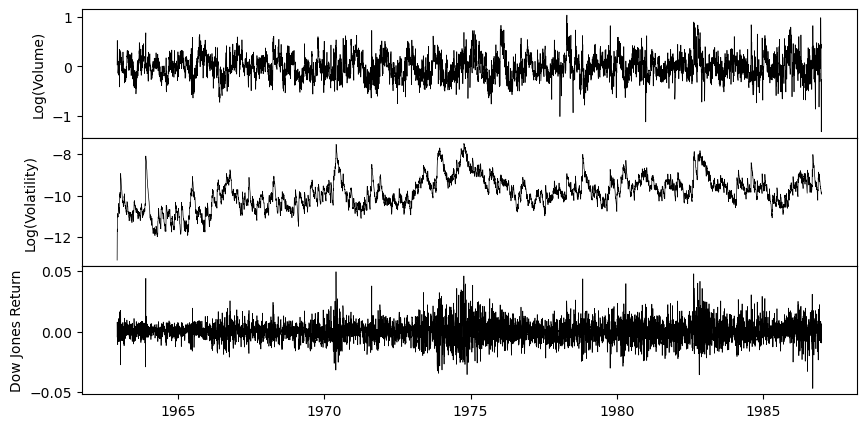

In [116]:
#plotting the three time series
plt.figure(figsize=(10,5))

plt.subplot(3,1,1)
plt.plot(plots.date, plots.log_volume, color ='black', linewidth=0.5)
plt.ylabel("Log(Volume)")
plt.xticks([])

plt.subplot(3,1,2)
plt.plot(plots.date, plots.log_volatility, color ='black', linewidth=0.5)
plt.ylabel("Log(Volatility)")
plt.xticks([])

plt.subplot(3,1,3)
plt.plot(plots.date, plots.DJ_return, color ='black', linewidth=0.5)
plt.ylabel("Dow Jones Return")
plt.gca().xaxis.set_major_locator(YearLocator(5))

plt.subplots_adjust(hspace=0)
plt.show()

Overall, we can see that there is pretty random movement on a daily basis with upward and downward movement changing almost everyday. However, on looking more closely, these plots provide valuable information about the stickiness of each time series.
- Volatility in the market has highest stickiness where high (or low) volatility on one day, is followed by volatility in the same direction on the next as well.
- Trading volume is also slightly sticky with a few seasonal patterns visible and moderate amount of similarity in volume change direction.
- The Dow Jones return however, do not have any amount of stickiness and the movements are mostly random, which is visible in the constant zig-zag pattern on the graph.

#### Correlation Plots

Plotting the autocorrelation with 20 lags to check if the past values have sizable correlations that can be helpful in predictions for future behavior. We also plot the correlation of trading volume with lagged values of volatility and returns to determine their use in predicting future trading volume.

In [9]:
from statsmodels.graphics.tsaplots import plot_acf

<Figure size 640x480 with 0 Axes>

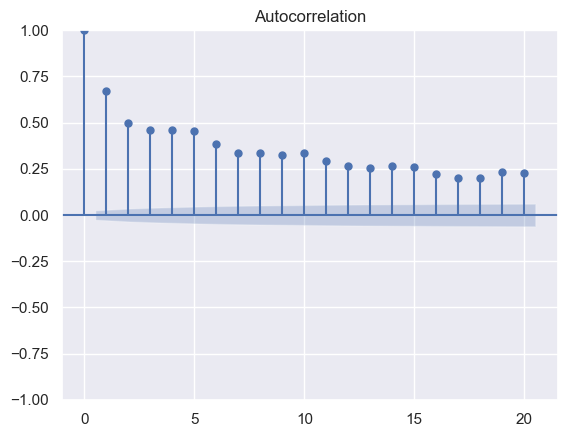

In [10]:
#autocorrelation between log volume and its lags
plt.figure()
plot_acf(NYSE['log_volume'], lags = 20)
plt.show()

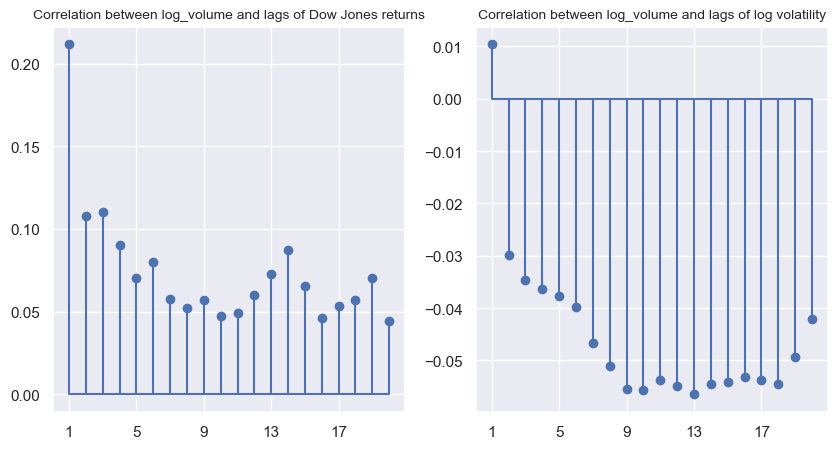

In [33]:
#plotting correlation between volume and lagged returns, volume and lagged log volatility

lags = 20
corrs_return = [NYSE['log_volume'].corr(NYSE['DJ_return'].shift(i)) for i in range(1, lags+1)]
corrs_vol = [NYSE['log_volume'].corr(NYSE['log_volatility'].shift(i)) for i in range(1, lags+1)]

fig, ax = plt.subplots(1,2, figsize=(10, 5))

#subplot1
ax[0].stem(range(1, lags+1), corrs_return, use_line_collection=True, linefmt='C0-', markerfmt='C0o', basefmt='C0')
ax[0].set_xticks(range(1, lags+1,4))
ax[0].set_title('Correlation between log_volume and lags of Dow Jones returns', fontsize=10)

#subplot2
ax[1].stem(range(1, lags+1), corrs_vol, use_line_collection=True, linefmt='C0-', markerfmt='C0o', basefmt='C0')
ax[1].set_xticks(range(1, lags+1,4))
ax[1].set_title('Correlation between log_volume and lags of log volatility', fontsize=10)
plt.show()


The above plots show that trading volume is highly autocorrelated and thus, its lagged values have a lot of predicting power. The next two plots show that lagged returns and volatility are also correlated with current trading volume, however, the magnitude is much lower. In case of volatility, there seems to be a negative relationship for 2 or more lags but again they have very low magnitudes. This could be explained by the relationship between volatility and volume, however on further examination of the data, we find that all values in the volatility column are actually negative and hence, the correlation value.

For the purposes of this project, we will consider five lagged values of all the three variables to predict tarding volume on the next day.

#### Creating the lagged variables

In [3]:
L=5
for s in range(1, L+1):
    NYSE[f'DJ_return_lag{s}'] = NYSE['DJ_return'].shift(s)
    NYSE[f'log_volume_lag{s}'] = NYSE['log_volume'].shift(s)
    NYSE[f'log_volatility_lag{s}'] = NYSE['log_volatility'].shift(s)

In [4]:
NYSE = NYSE.reindex(sorted(NYSE.columns), axis=1)
NYSE

,DJ_return,DJ_return_lag1,DJ_return_lag2,DJ_return_lag3,DJ_return_lag4,DJ_return_lag5,day_of_week,log_volatility,log_volatility_lag1,log_volatility_lag2,log_volatility_lag3,log_volatility_lag4,log_volatility_lag5,log_volume,log_volume_lag1,log_volume_lag2,log_volume_lag3,log_volume_lag4,log_volume_lag5,train
date,,,,,,,,,,,,,,,,,,,,
1962-12-03,-0.004461,NaN,NaN,NaN,NaN,NaN,mon,-13.127403,NaN,NaN,NaN,NaN,NaN,0.032573,NaN,NaN,NaN,NaN,NaN,True
1962-12-04,0.007813,-0.004461,NaN,NaN,NaN,NaN,tues,-11.749305,-13.127403,NaN,NaN,NaN,NaN,0.346202,0.032573,NaN,NaN,NaN,NaN,True
1962-12-05,0.003845,0.007813,-0.004461,NaN,NaN,NaN,wed,-11.665609,-11.749305,-13.127403,NaN,NaN,NaN,0.525306,0.346202,0.032573,NaN,NaN,NaN,True
1962-12-06,-0.003462,0.003845,0.007813,-0.004461,NaN,NaN,thur,-11.626772,-11.665609,-11.749305,-13.127403,NaN,NaN,0.210182,0.525306,0.346202,0.032573,NaN,NaN,True
1962-12-07,0.000568,-0.003462,0.003845,0.007813,-0.004461,NaN,fri,-11.728130,-11.626772,-11.665609,-11.749305,-13.127403,NaN,0.044187,0.210182,0.525306,0.346202,0.032573,NaN,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1986-12-24,0.006514,-0.006150,-0.001385,0.008345,-0.002866,-0.009262,wed,-9.807366,-9.782214,-9.746214,-9.644138,-9.652473,-9.559975,-0.236104,0.450780,0.366152,0.986704,0.025079,-0.043366,False
1986-12-26,0.001825,0.006514,-0.006150,-0.001385,0.008345,-0.002866,fri,-9.906025,-9.807366,-9.782214,-9.746214,-9.644138,-9.652473,-1.322425,-0.236104,0.450780,0.366152,0.986704,0.025079,False
1986-12-29,-0.009515,0.001825,0.006514,-0.006150,-0.001385,0.008345,mon,-9.827660,-9.906025,-9.807366,-9.782214,-9.746214,-9.644138,-0.371237,-1.322425,-0.236104,0.450780,0.366152,0.986704,False


In [5]:
#extracting the predictors
preds = []
for s in range(1, L+1):
    preds.append(f'DJ_return_lag{s}')
    preds.append(f'log_volume_lag{s}')
    preds.append(f'log_volatility_lag{s}')

#### Train-Test Split

In [7]:
train = NYSE[NYSE['train'] == True].dropna()
test = NYSE[NYSE['train'] == False].dropna()

Here, the column 'log_volume_lag1' is yesterday's data and thus can be used as the predicted value.

## 3 Baseline Model

Using the straw man (using yesterday’s value of log trading volume to predict that of today) as the baseline method. Since this model does not involve any tuning, we can directly find the training and testing performance.

In [8]:
from sklearn.metrics import r2_score

In [36]:
#training data performance evaluation
baseline_tr_r2 = r2_score(train.log_volume, train.log_volume_lag1)
baseline_tr_r2

0.4199386914132621

In [37]:
#testing data performance evaluation
baseline_ts_r2 = r2_score(test.log_volume, test.log_volume_lag1)
baseline_ts_r2

0.18026287838158628

#### Observations:

The baseline method does a really bad job at forecasting next day's trading volume based on T-1 trading volume. It does not get the right prediction even 50% of the time in training and gets even worse with testing by explaining less than 20% of the variation in next day's trading volume.

## 4 Autoregression with ElasticNet Regularization

Fitting an ordinary least squares regression of the form:  
$$
\hat v_t = \hat \beta_0 + \hat \beta_1 v_{t-1} + \hat \beta_2 v_{t-2} + \cdots + \hat \beta_L v_{t-L},
$$

where L = 5 lags. This represents an **AR(5)** model.

In [9]:
#simple linear regression model using the 5 lags of log volume as predictors
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

In [13]:
ARpreds = [f'log_volume_lag{s}' for s in range(1, L+1)]

In [14]:
x_train = train[ARpreds]
x_test = test[ARpreds]

In [15]:
#preprocessing
scaler = StandardScaler()
x_tr_scaled = scaler.fit_transform(x_train)
x_ts_scaled = scaler.fit_transform(x_test)

In [15]:
#fitting model
AR = LinearRegression().fit(x_tr_scaled, train.log_volume)

In [16]:
#making predictions on training data
y_tr_pred = AR.predict(x_tr_scaled)

#training data performance evaluation
AR_tr_r2 = r2_score(train.log_volume, y_tr_pred)
AR_tr_r2

0.5429019055251896

In [59]:
#making predictions on testing data
y_ts_pred = AR.predict(x_ts_scaled)

#testing data performance evaluation
AR_ts_r2 = r2_score(test.log_volume, y_ts_pred)
AR_ts_r2

0.3728070807807079

### Tuning AR(5) with Elastic Net Regularization using all 3 features

In [16]:
x_train = train[preds]
x_test = test[preds]

#preprocessing
from sklearn.pipeline import Pipeline
scaler = StandardScaler()

In [21]:
#model
from sklearn.linear_model import ElasticNet

enet_mod = ElasticNet(
            alpha = 1,
            l1_ratio = 0.5,
            max_iter = 10000,
            warm_start = True,
            random_state = 425
            )
enet_mod

ElasticNet(alpha=1, max_iter=10000, random_state=425, warm_start=True)

In [22]:
#pipeline workflow
pipe = Pipeline(steps = [
  ("std_tf", scaler),
  ("model", enet_mod)
  ])
pipe

Pipeline(steps=[('std_tf', StandardScaler()),
                ('model',
                 ElasticNet(alpha=1, max_iter=10000, random_state=425,
                            warm_start=True))])

In [46]:
#tuning parameters
alphas = np.logspace(start = -3, stop = 1, base = 10, num = 50)
l1_ratios = np.linspace(start = 0, stop = 1, num = 5)
tuned_parameters = {
  "model__alpha": alphas,
  "model__l1_ratio": l1_ratios
  }
tuned_parameters

{'model__alpha': array([1.00000000e-03, 1.20679264e-03, 1.45634848e-03, 1.75751062e-03,
        2.12095089e-03, 2.55954792e-03, 3.08884360e-03, 3.72759372e-03,
        4.49843267e-03, 5.42867544e-03, 6.55128557e-03, 7.90604321e-03,
        9.54095476e-03, 1.15139540e-02, 1.38949549e-02, 1.67683294e-02,
        2.02358965e-02, 2.44205309e-02, 2.94705170e-02, 3.55648031e-02,
        4.29193426e-02, 5.17947468e-02, 6.25055193e-02, 7.54312006e-02,
        9.10298178e-02, 1.09854114e-01, 1.32571137e-01, 1.59985872e-01,
        1.93069773e-01, 2.32995181e-01, 2.81176870e-01, 3.39322177e-01,
        4.09491506e-01, 4.94171336e-01, 5.96362332e-01, 7.19685673e-01,
        8.68511374e-01, 1.04811313e+00, 1.26485522e+00, 1.52641797e+00,
        1.84206997e+00, 2.22299648e+00, 2.68269580e+00, 3.23745754e+00,
        3.90693994e+00, 4.71486636e+00, 5.68986603e+00, 6.86648845e+00,
        8.28642773e+00, 1.00000000e+01]),
 'model__l1_ratio': array([0.  , 0.25, 0.5 , 0.75, 1.  ])}

In [47]:
#cross validation for selection of best parameters
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit


search = GridSearchCV(
  pipe,
  tuned_parameters,
  cv = TimeSeriesSplit(n_splits=5), 
  scoring = "r2",
  # Refit the best model on the whole data set
  refit = True
  )

In [48]:
# Fit CV
search.fit(x_train, train.log_volume)

C:\Users\agarw\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.797e+00, tolerance: 2.662e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\agarw\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.256e+01, tolerance: 6.028e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linea

C:\Users\agarw\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.258e+01, tolerance: 6.028e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\agarw\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.083e+01, tolerance: 9.695e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linea

C:\Users\agarw\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.089e+01, tolerance: 9.695e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\agarw\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.073e+01, tolerance: 1.379e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linea

C:\Users\agarw\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.087e+01, tolerance: 1.379e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\agarw\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.072e+01, tolerance: 1.907e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linea

C:\Users\agarw\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.103e+01, tolerance: 1.907e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\agarw\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.891e+00, tolerance: 2.662e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linea

C:\Users\agarw\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.951e+00, tolerance: 2.662e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\agarw\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.286e+01, tolerance: 6.028e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linea

C:\Users\agarw\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.305e+01, tolerance: 6.028e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\agarw\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.170e+01, tolerance: 9.695e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linea

C:\Users\agarw\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.217e+01, tolerance: 9.695e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\agarw\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.252e+01, tolerance: 1.379e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linea

C:\Users\agarw\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.344e+01, tolerance: 1.379e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\agarw\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.435e+01, tolerance: 1.907e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linea

C:\Users\agarw\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.622e+01, tolerance: 1.907e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\agarw\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.809e+00, tolerance: 2.662e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linea

C:\Users\agarw\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.266e+00, tolerance: 2.662e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\agarw\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.562e+01, tolerance: 6.028e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linea

C:\Users\agarw\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.693e+01, tolerance: 6.028e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\agarw\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.795e+01, tolerance: 9.695e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linea

C:\Users\agarw\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.058e+01, tolerance: 9.695e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\agarw\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.396e+01, tolerance: 1.379e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linea

C:\Users\agarw\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.834e+01, tolerance: 1.379e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\agarw\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.570e+01, tolerance: 1.907e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linea

C:\Users\agarw\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.259e+01, tolerance: 1.907e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\agarw\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.066e+01, tolerance: 2.662e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linea

C:\Users\agarw\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.147e+01, tolerance: 2.662e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\agarw\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.548e+01, tolerance: 6.028e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linea

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Pipeline(steps=[('std_tf', StandardScaler()),
                                       ('model',
                                        ElasticNet(alpha=1, max_iter=10000,
                                                   random_state=425,
                                                   warm_start=True))]),
             param_grid={'model__alpha': array([1.00000000e-03, 1.20679264e-03, 1.45634848e-03, 1.75751062e-03,
       2.12095089e-03, 2.55954792e-03, 3.08884...
       1.93069773e-01, 2.32995181e-01, 2.81176870e-01, 3.39322177e-01,
       4.09491506e-01, 4.94171336e-01, 5.96362332e-01, 7.19685673e-01,
       8.68511374e-01, 1.04811313e+00, 1.26485522e+00, 1.52641797e+00,
       1.84206997e+00, 2.22299648e+00, 2.68269580e+00, 3.23745754e+00,
       3.90693994e+00, 4.71486636e+00, 5.68986603e+00, 6.86648845e+00,
       8.28642773e+00, 1.00000000e+01]),
                  

In [49]:
cv_res = pd.DataFrame({
  "alpha": np.array(search.cv_results_["param_model__alpha"]),
  "r2": search.cv_results_["mean_test_score"],
  "l1ratio": search.cv_results_["param_model__l1_ratio"]
  })

cv_res

,alpha,r2,l1ratio
0,0.001,0.555709,0.0
1,0.001,0.554315,0.25
2,0.001,0.552398,0.5
3,0.001,0.550192,0.75
4,0.001,0.547809,1.0
...,...,...,...
245,10.0,0.209347,0.0
246,10.0,-0.015263,0.25
247,10.0,-0.015263,0.5
248,10.0,-0.015263,0.75


<Figure size 640x480 with 0 Axes>

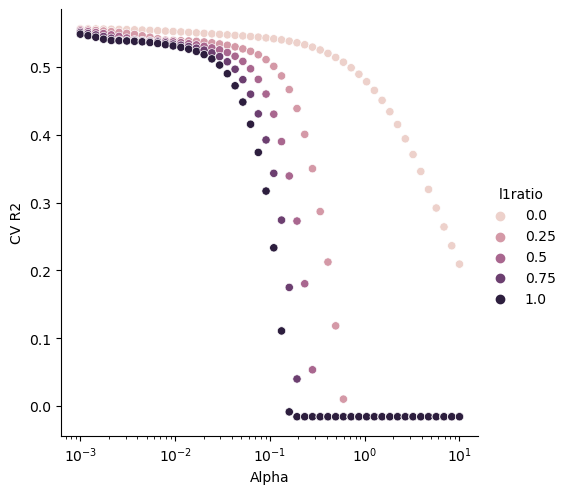

In [51]:
#visualising cv results

plt.figure()
#sns.set(font_scale = 1)
sns.relplot(
  data = cv_res,
  x = "alpha",
  y = "r2",
  hue = "l1ratio",
  ).set(
    xlabel = "Alpha",
    ylabel = "CV R2",
    xscale = "log"
)
plt.show()

In [53]:
search.best_estimator_

Pipeline(steps=[('std_tf', StandardScaler()),
                ('model',
                 ElasticNet(alpha=0.001, l1_ratio=0.0, max_iter=10000,
                            random_state=425, warm_start=True))])

In [52]:
#training performance

enet_tr_r2 = search.best_score_
enet_tr_r2

0.5557088393101248

In [54]:
#testing performance

enet_ts_r2 = r2_score(test.log_volume, search.best_estimator_.predict(x_test))
enet_ts_r2

0.4129073468536335

#### Observations:

The best fit model here that gives the highest R2 score after cross validation has an alpha ~ 0 and L1 ratio = 0 as well. This implies that almost no penalty is applied and it is a Ridge Regression essentially. This would imply that the best R2 score is achieved when using all the predictors. This would be expected as R2 always increases as more predictors are added to the regression model. Thus, since this is essentially a multiple regression model, adjusted R2 would be a better scoring metric!

#### Trying adjusted R2 as the metric

Source: https://stackoverflow.com/questions/68222193/calculate-adjusted-r2-using-gridsearchcv

In [56]:
def adj_r2(estimator, X, y_true):
    n, p = X.shape
    pred = estimator.predict(X)
    return 1 - ((1 - r2_score(y_true, pred)) * (n - 1))/(n-p-1)


adjr2_search = GridSearchCV(
  pipe,
  tuned_parameters,
  cv = TimeSeriesSplit(n_splits=5), 
  scoring = {"adj R2": adj_r2},
  # Refit the best model on the whole data set
  refit="adj R2"
  )

In [57]:
adjr2_search.fit(x_train, train.log_volume)

C:\Users\agarw\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.797e+00, tolerance: 2.662e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\agarw\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.256e+01, tolerance: 6.028e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linea

C:\Users\agarw\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.258e+01, tolerance: 6.028e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\agarw\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.083e+01, tolerance: 9.695e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linea

C:\Users\agarw\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.089e+01, tolerance: 9.695e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\agarw\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.073e+01, tolerance: 1.379e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linea

C:\Users\agarw\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.087e+01, tolerance: 1.379e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\agarw\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.072e+01, tolerance: 1.907e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linea

C:\Users\agarw\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.103e+01, tolerance: 1.907e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\agarw\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.891e+00, tolerance: 2.662e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linea

C:\Users\agarw\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.951e+00, tolerance: 2.662e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\agarw\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.286e+01, tolerance: 6.028e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linea

C:\Users\agarw\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.305e+01, tolerance: 6.028e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\agarw\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.170e+01, tolerance: 9.695e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linea

C:\Users\agarw\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.217e+01, tolerance: 9.695e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\agarw\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.252e+01, tolerance: 1.379e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linea

C:\Users\agarw\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.344e+01, tolerance: 1.379e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\agarw\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.435e+01, tolerance: 1.907e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linea

C:\Users\agarw\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.622e+01, tolerance: 1.907e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\agarw\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.809e+00, tolerance: 2.662e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linea

C:\Users\agarw\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.266e+00, tolerance: 2.662e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\agarw\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.562e+01, tolerance: 6.028e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linea

C:\Users\agarw\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.795e+01, tolerance: 9.695e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\agarw\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.030e+01, tolerance: 1.379e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linea

C:\Users\agarw\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.396e+01, tolerance: 1.379e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\agarw\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.934e+01, tolerance: 1.907e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linea

C:\Users\agarw\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.570e+01, tolerance: 1.907e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\agarw\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.760e+00, tolerance: 2.662e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linea

C:\Users\agarw\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.066e+01, tolerance: 2.662e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\agarw\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.349e+01, tolerance: 6.028e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linea

C:\Users\agarw\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.130e+01, tolerance: 9.695e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\agarw\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.896e+01, tolerance: 1.379e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linea

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Pipeline(steps=[('std_tf', StandardScaler()),
                                       ('model',
                                        ElasticNet(alpha=1, max_iter=10000,
                                                   random_state=425,
                                                   warm_start=True))]),
             param_grid={'model__alpha': array([1.00000000e-03, 1.20679264e-03, 1.45634848e-03, 1.75751062e-03,
       2.12095089e-03, 2.55954792e-03, 3.08884...
       4.09491506e-01, 4.94171336e-01, 5.96362332e-01, 7.19685673e-01,
       8.68511374e-01, 1.04811313e+00, 1.26485522e+00, 1.52641797e+00,
       1.84206997e+00, 2.22299648e+00, 2.68269580e+00, 3.23745754e+00,
       3.90693994e+00, 4.71486636e+00, 5.68986603e+00, 6.86648845e+00,
       8.28642773e+00, 1.00000000e+01]),
                         'model__l1_ratio': array([0.  , 0.25, 0.5 , 0.75, 1.  ])},
     

In [59]:
adjr2_search.best_estimator_

Pipeline(steps=[('std_tf', StandardScaler()),
                ('model',
                 ElasticNet(alpha=0.001, l1_ratio=0.0, max_iter=10000,
                            random_state=425, warm_start=True))])

In [60]:
adjr2_search.best_score_

0.5461335987780155

In [61]:
r2_score(test.log_volume, adjr2_search.best_estimator_.predict(x_test))

0.4129073468536335

The same result is achieved with adjusted R2 as well because it again optimises to a model that uses all 15 predictors.

## 5 Autoregression by MLP

In [70]:
#model
from sklearn.neural_network import MLPRegressor

mlp_mod = MLPRegressor(
  hidden_layer_sizes = (5, 3),     #first layer has 8 perceptrons, second layer has 4 perceptrons
  activation = 'relu',
  solver = 'adam',
  batch_size = 16,
  random_state = 425,     #random number generation for weights and bias initialization
  shuffle=False            
  )
mlp_mod

MLPRegressor(batch_size=16, hidden_layer_sizes=(5, 3), random_state=425,
             shuffle=False)

In [71]:
#pipeline workflow
pipe = Pipeline(steps = [
  ("std_tf", scaler),
  ("model", mlp_mod)
  ])
pipe

Pipeline(steps=[('std_tf', StandardScaler()),
                ('model',
                 MLPRegressor(batch_size=16, hidden_layer_sizes=(5, 3),
                              random_state=425, shuffle=False))])

In [72]:
#tuning parameters
hls_grid = [(4), (8), (12), (8, 4), (12, 6), (5,3,2)] # hidden layer size
bs_grid = [4, 8, 12, 16, 20, 24, 28, 32] # batch sizes
tuned_parameters = {
  "model__hidden_layer_sizes": hls_grid,
  "model__batch_size": bs_grid
  }
tuned_parameters 

{'model__hidden_layer_sizes': [4, 8, 12, (8, 4), (12, 6), (5, 3, 2)],
 'model__batch_size': [4, 8, 12, 16, 20, 24, 28, 32]}

In [73]:
#cross validation for selection of best parameters

search = GridSearchCV(
  pipe,
  tuned_parameters,
  cv = TimeSeriesSplit(n_splits=5), 
  scoring = "r2",
  refit = True
  )

In [74]:
# Fit CV
search.fit(x_train, train.log_volume)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Pipeline(steps=[('std_tf', StandardScaler()),
                                       ('model',
                                        MLPRegressor(batch_size=16,
                                                     hidden_layer_sizes=(5, 3),
                                                     random_state=425,
                                                     shuffle=False))]),
             param_grid={'model__batch_size': [4, 8, 12, 16, 20, 24, 28, 32],
                         'model__hidden_layer_sizes': [4, 8, 12, (8, 4),
                                                       (12, 6), (5, 3, 2)]},
             scoring='r2')

<Figure size 640x480 with 0 Axes>

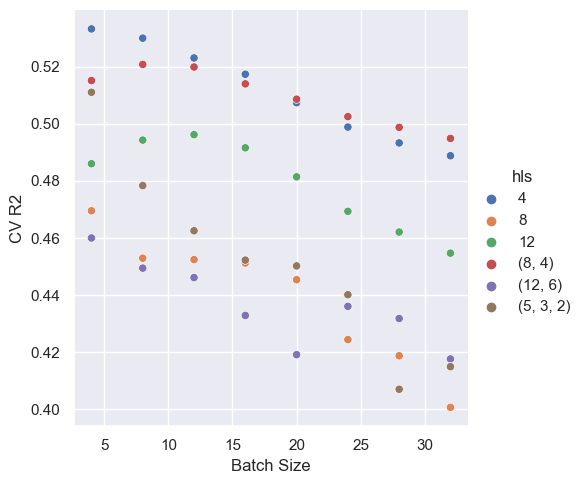

In [77]:
#visualising CV results

cv_res = pd.DataFrame({
  "bs": np.array(search.cv_results_["param_model__batch_size"]),
  "r2": search.cv_results_["mean_test_score"],
  "hls": search.cv_results_["param_model__hidden_layer_sizes"]
  })

plt.figure()
sns.set(font_scale = 1)
sns.relplot(
  # kind = "line",
  data = cv_res,
  x = "bs",
  y = "r2",
  hue = "hls"
  ).set(
    # xscale = "log",
    xlabel = "Batch Size",
    ylabel = "CV R2"
    )
plt.show()

In [80]:
search.best_estimator_

Pipeline(steps=[('std_tf', StandardScaler()),
                ('model',
                 MLPRegressor(batch_size=4, hidden_layer_sizes=4,
                              random_state=425, shuffle=False))])

In [79]:
#training performance
mlp_tr_r2 = search.best_score_
mlp_tr_r2

0.5332484706950027

In [81]:
#testing performance
mlp_ts_r2 = r2_score(test.log_volume, search.best_estimator_.predict(x_test))
mlp_ts_r2

0.4184088409642621

#### Observations:

After tuning, the best model that achieves highest R2 value is one with a simple architecture of a one layer model with 4 neurons, using a batch size of 4. The small batch size means that the weights and biases of the model are updated more frequently during training, which could help prevent overfitting.  
The final training performance is lower than the Elastic Net AR model but the testing performance improves marginally when using an MLP neural network model.

## 6 LSTM forecaster

In [12]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

In [81]:
#preprocessing
lstm_train = train[['log_volume', 'log_volatility','DJ_return']]
lstm_test = test[['log_volume', 'log_volatility','DJ_return']]

In [82]:
#scaled preprocessing
lstm_scaled_tr = scaler.fit_transform(lstm_train)
lstm_scaled_ts = scaler.fit_transform(lstm_test)

In [85]:
lstm_scaled_tr.shape

(4276, 3)

In [84]:
lstm_scaled_ts.shape

(1770, 3)

In [66]:
#training data

x_train = []
y_train = []

input_size = 5   #depicts the number of time lags
for i in range(input_size, len(lstm_scaled_tr)):
    x_train.append(lstm_scaled_tr[i-input_size:i, :])
    y_train.append(lstm_scaled_tr[i,0])

x_train, y_train = np.array(x_train), np.array(y_train)  

In [67]:
print(x_train.shape)    #num_samples, input_size, input_dimension (# of features)
print(y_train.shape)

(4271, 5, 3)
(4271,)


In [104]:
#model
model = keras.Sequential([
  layers.LSTM(units = 20, dropout = 0.5, recurrent_dropout = 0.3),   #can try different dropout rates too
  layers.Dense(units = 1, activation = 'relu')
])

model.compile(
  loss = 'mean_squared_error',
  optimizer = 'adam'
)

In [105]:
lstm = model.fit(
  x_train, y_train,
  batch_size = 16,
  epochs = 10,
  validation_split = 0.2, 
  verbose = 0
)
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 20)                1920      
                                                                 
 dense_7 (Dense)             (None, 1)                 21        
                                                                 
Total params: 1,941
Trainable params: 1,941
Non-trainable params: 0
_________________________________________________________________


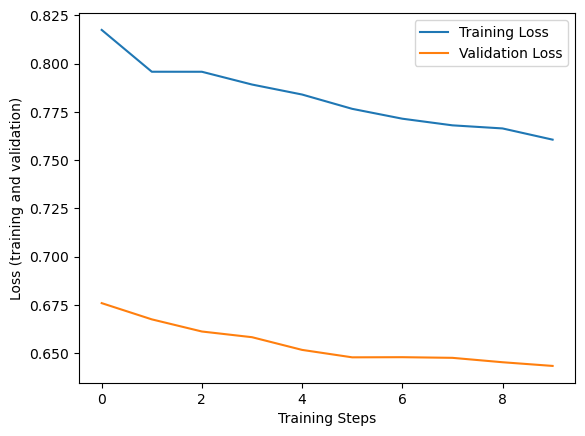

In [72]:
#visualising training process
plt.figure()

plt.plot(lstm.history["loss"])
plt.plot(lstm.history["val_loss"])

plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.legend(['Training Loss','Validation Loss'])
plt.show()

In [106]:
#training r2
r2_score(y_train, model.predict(x_train))

134/134 [==============================] - 1s 3ms/step


0.28265001604388484

In [100]:
#testing data

x_test = []
y_test = []

input_size = 5   #depicts the number of time lags
for i in range(input_size, len(lstm_scaled_ts)):
    x_test.append(lstm_scaled_ts[i-input_size:i, :])
    y_test.append(lstm_scaled_ts[i,0])

x_test, y_test = np.array(x_test), np.array(y_test)

In [101]:
print(x_test.shape)    #num_samples, inpur_size, input_dimension (# of features)
print(y_test.shape)

(1765, 5, 3)
(1765,)


In [107]:
#testing r2
r2_score(y_test, model.predict(x_test))

56/56 [==============================] - 0s 3ms/step


0.2309639323160858

Since these R-square values are very low, we will now tune the number of neurons, the activation function, batch size and number of epochs.

### Tuning epochs, neurons, batch_size, activation function

In [14]:
from keras.wrappers.scikit_learn import KerasRegressor

In [122]:
from keras.optimizers import Adam

learning_rate = 0.01
optimizer = Adam(learning_rate=learning_rate)

In [125]:
def create_model(neurons, activation):
    model = keras.Sequential([
      layers.LSTM(units = neurons, dropout = 0.5, recurrent_dropout = 0.3),
      layers.Dense(units = 1, activation = activation)
    ])
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return(model)
model = KerasRegressor(build_fn=create_model, verbose=0)

param_grid = {'batch_size': [16, 32, 64],
              'epochs': [10, 20],
             'neurons': [15,25,50],
             'activation':["relu","tanh"]}

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=TimeSeriesSplit(n_splits=5), scoring='r2')
grid_result = grid.fit(x_train, y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

C:\Users\agarw\AppData\Local\Temp\ipykernel_19172\3842025233.py:8: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_model, verbose=0)


Best: 0.507500 using {'activation': 'tanh', 'batch_size': 32, 'epochs': 20, 'neurons': 25}


In [128]:
#training r2
lstm_tr_r2 = grid_result.best_score_
lstm_tr_r2

0.5075000406713679

In [129]:
#testing r2
lstm_ts_r2 = r2_score(y_test, grid_result.best_estimator_.predict(x_test))
lstm_ts_r2

0.36805334318024285

#### Observations:

After tuning, the best model that achieves highest R2 value is a recurrent neural network LSTM model with one layer, 25 neurons or perceptrons in the LSTM layer using a batch size of 32 samples and running the training model through 20 epochs.Again, it is interesting to note how the batch size takes the tradeoff of quick fitting and overfitting into regard to find a balance. The testing performance and accuracy could be improved further by tuning the learning rate as well.

## 7 Random Forest forecaster

In [11]:
from sklearn.ensemble import RandomForestRegressor

In [12]:
#split into train-test again since different from lstm

x_train = train[preds]
x_test = test[preds]
y_train = train.log_volume
y_test = test.log_volume

In [164]:
#model

rf_mod =  RandomForestRegressor(
  n_estimators = 100, 
  criterion = 'squared_error',
  max_features = 'sqrt',
  oob_score = True,     #using out of bag samples to prevent overfitting
  random_state = 425
  )

In [165]:
#pipeline

pipe = Pipeline(steps = [
  ("model", rf_mod)
  ])
pipe

Pipeline(steps=[('model',
                 RandomForestRegressor(max_features='sqrt', oob_score=True,
                                       random_state=425))])

In [166]:
#tuning hyperparameters

B_grid = [50, 75, 100, 125, 150]
m_grid = ['sqrt', 0.5, 1.0]    #max_features = 1.0 is same as bagging (using all features), 0.5 uses only half the features
tuned_parameters = {
  "model__n_estimators": B_grid,
  "model__max_features": m_grid
  }
tuned_parameters  

{'model__n_estimators': [50, 75, 100, 125, 150],
 'model__max_features': ['sqrt', 0.5, 1.0]}

In [167]:
#cross validation for selection of best parameters

search = GridSearchCV(
  pipe,
  tuned_parameters,
  cv = TimeSeriesSplit(n_splits=5), 
  scoring = "r2",
  refit = True
  )

In [168]:
#fit cv
search.fit(x_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Pipeline(steps=[('model',
                                        RandomForestRegressor(max_features='sqrt',
                                                              oob_score=True,
                                                              random_state=425))]),
             param_grid={'model__max_features': ['sqrt', 0.5, 1.0],
                         'model__n_estimators': [50, 75, 100, 125, 150]},
             scoring='r2')

<Figure size 640x480 with 0 Axes>

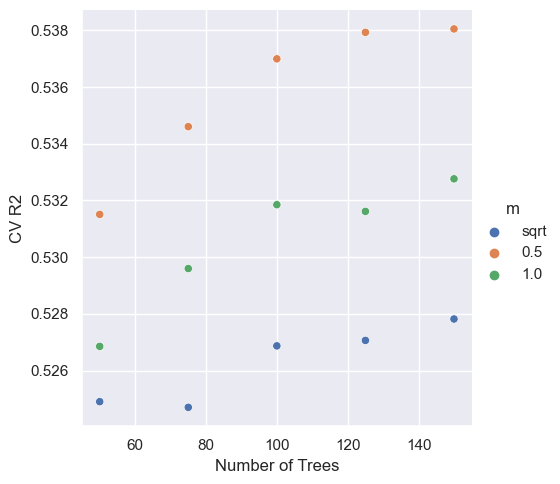

In [169]:
#visualising CV results

cv_res = pd.DataFrame({
  "B": np.array(search.cv_results_["param_model__n_estimators"]),
  "r2": search.cv_results_["mean_test_score"],
  "m": search.cv_results_["param_model__max_features"]
  })

plt.figure()
sns.set(font_scale = 1)
sns.relplot(
  data = cv_res,
  x = "B",
  y = "r2",
  hue = "m",
  ).set(
    xlabel = "Number of Trees",
    ylabel = "CV R2"
)
plt.show()

In [170]:
search.best_estimator_

Pipeline(steps=[('model',
                 RandomForestRegressor(max_features=0.5, n_estimators=150,
                                       oob_score=True, random_state=425))])

<Figure size 640x480 with 0 Axes>

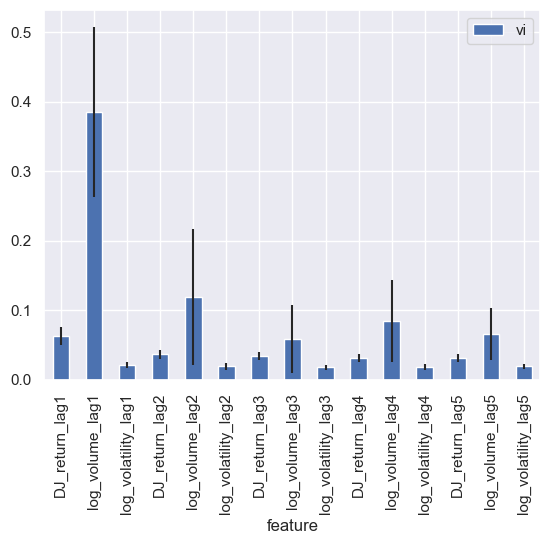

In [171]:
#feature importance
vi_df = pd.DataFrame({
  "feature": x_train.columns,
  "vi": search.best_estimator_['model'].feature_importances_,
  "vi_std": np.std([tree.feature_importances_ for tree in search.best_estimator_['model'].estimators_], axis = 0)
  })              #axis=0 because calculating across col - each col corresponds to a feature from x_train and there are 150
                  #"imp" measures for each feature- so taking std dev for those 150 obs for 1 feature- doing for each feature
plt.figure()
vi_df.plot.bar(x = "feature", y = "vi", yerr = "vi_std")
plt.show()

In [174]:
#training performance
rf_tr_r2 = search.best_score_
rf_tr_r2

0.5380496356585099

In [175]:
#testing performance
rf_ts_r2 = r2_score(y_test, search.best_estimator_.predict(x_test))
rf_ts_r2

0.40052735766573766

#### Observations:

The above model and plots show that when using the Random Forest model, the highest R^2 is achieved when we randomly use only half of all the features in every tree and fit 150 trees to predict the trading volume for the next day. Further, the feature importance plot shows that the most significant and important feature when predicting the next day's log volume is the lagged value of volume itself. It is further interesting to note that the most important features are all the lags of trading volume used in the model, compared to other features. This is consistent with the ACF plot that we visualised earlier. All other features reduce MSE by a very small amount when used as the splitting node in the tree and hence have low importance.

## 8 Boosting forecaster (XGBoost)

In [15]:
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb

In [16]:
#model

xgb_mod = xgb.XGBRegressor(
    n_estimators = 50, #number of trees- will be tuned
    max_depth = 3,
    learning_rate = 1.0,  #will be tuned
    colsample_bytree = 0.8,    #number of features to use in each tree
    random_state = 425
    #min_child_weight = 5    #stop splitting when you reach 5 obs in a node (similar idea not exactly 5--something with weights)
    #prevents overfitting but very high can cause underfitting
)

In [17]:
#pipeline
pipe = Pipeline(steps = [
  ("model", xgb_mod)
  ])
pipe

Pipeline(steps=[('model',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=0.8, early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, gamma=None, gpu_id=None,
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None, learning_rate=1.0,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=3, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, n_estimators=50,
                              n_jobs=None, num_parallel_tree=None,
                              pr

In [44]:
#tuning parameters

d_grid = [1,2,3,4]
B_grid = [100, 150, 200, 250, 300, 350, 400]
lambda_grid = np.linspace(start = 0.05, stop = 0.1, num = 5)
num_features = [0.5,0.8,1]

tuned_parameters = {
  "model__max_depth": d_grid,
  "model__n_estimators": B_grid,
  "model__learning_rate": lambda_grid,
  "model__colsample_bytree": num_features
  }
tuned_parameters  

{'model__max_depth': [1, 2, 3, 4],
 'model__n_estimators': [100, 150, 200, 250, 300, 350, 400],
 'model__learning_rate': array([0.05  , 0.0625, 0.075 , 0.0875, 0.1   ]),
 'model__colsample_bytree': [0.5, 0.8, 1]}

In [45]:
#cross validation for selection of best parameters

search = GridSearchCV(
  pipe,
  tuned_parameters,
  cv = TimeSeriesSplit(n_splits=5), 
  scoring = "r2", 
  refit = True
  )

In [46]:
#fit cv
search.fit(x_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Pipeline(steps=[('model',
                                        XGBRegressor(base_score=None,
                                                     booster=None,
                                                     callbacks=None,
                                                     colsample_bylevel=None,
                                                     colsample_bynode=None,
                                                     colsample_bytree=0.8,
                                                     early_stopping_rounds=None,
                                                     enable_categorical=False,
                                                     eval_metric=None,
                                                     feature_types=None,
                                                     gamma=None, gpu_id=N...
                                               

<Figure size 640x480 with 0 Axes>

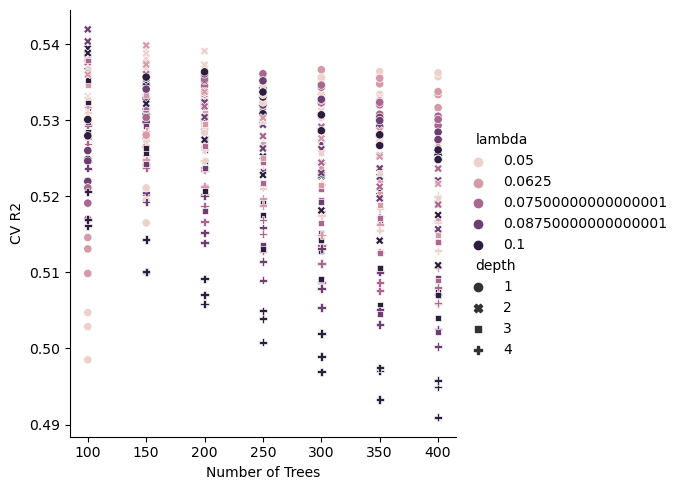

In [59]:
#visualising CV results

cv_res = pd.DataFrame({
  "B": np.array(search.cv_results_["param_model__n_estimators"]),
  "r2": search.cv_results_["mean_test_score"],
  "lambda": search.cv_results_["param_model__learning_rate"],
  "depth": search.cv_results_["param_model__max_depth"]
  })

plt.figure()
sns.relplot(
  data = cv_res,
  x = "B",
  y = "r2",
  hue = "lambda",
  style = "depth"  
  #size = "num_features"  
  ).set(
    xlabel = "Number of Trees",
    ylabel = "CV R2"
)
plt.show()

In [60]:
search.best_estimator_[0].colsample_bytree

0.8

In [52]:
#training performance
xgb_tr_r2 = search.best_score_
xgb_tr_r2

0.5419220302741492

In [53]:
#testing performance
xgb_ts_r2 = r2_score(y_test, search.best_estimator_.predict(x_test))
xgb_ts_r2

0.41305958855326275

#### Observations:

The model with highest training performance when using the XGBoost algorithm is one with 100 trees, with a maximum of 2 layers in every tree, using 80% of the features when building a new node. This model also uses a slightly lower learning rate of 0.087. Thus, everytime a new tree is built to improve on the errors of the previous tree, only 80% of the features are used for prediction highlighting that not all the features contribute to explaining the variation in predicted trading voilume. This is consistent with the feature importance graph from Random Forest model.

## 9 Summary

In [78]:
data = {'Model': ['Baseline', 'AR(5)', 'AR(5) MLP', 'LSTM', 'Random Forest', 'Boosting (XGBoost)'],
        'CV R\u00b2': [baseline_tr_r2, enet_tr_r2, mlp_tr_r2,lstm_tr_r2, rf_tr_r2, xgb_tr_r2],
       'Test R\u00b2': [baseline_ts_r2, enet_ts_r2, mlp_ts_r2, lstm_ts_r2, rf_ts_r2, xgb_ts_r2]}

In [79]:
final = pd.DataFrame(data)
final = final.set_index('Model')
final

,CV R²,Test R²
Model,,
Baseline,0.419939,0.180263
AR(5),0.555709,0.412907
AR(5) MLP,0.533248,0.418409
LSTM,0.507500,0.368053
Random Forest,0.538050,0.400527
Boosting (XGBoost),0.541922,0.413060


#### Conclusion:

With the given dataset, the best performing model in terms of highest test R2 is an Autoregressive Multi Layer Perceptron model with test R2 of ~42% and the worst performing model is the LSTM model with test R2 of 36.8% after the baseline straw man model.